In [1]:
import pandas as pd
from PIL import Image, ImageDraw
import numpy as np

In [2]:
DIRECTROY = 'data'
MODEL_PATH = 'models'
IMG_SIZE = 224

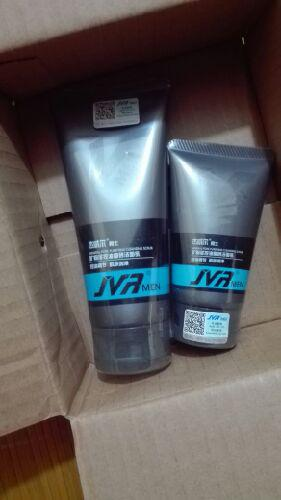

In [3]:
a = Image.open(f'./{DIRECTROY}/train/115601.jpg').convert('RGB')
a

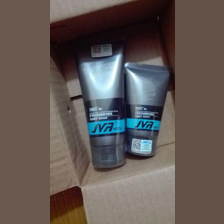

In [4]:
w, h = a.size
if w < h:
    scale = h/IMG_SIZE
    w = int(w/scale)
    h = IMG_SIZE
    a = a.resize((w, h))
    lb= np.array([a.load()[0,x] for x in range(h)])
    rb = np.array([a.load()[w-1,x] for x in range(h)])
    lb = lb.mean(axis=0).astype('uint8')
    rb = rb.mean(axis=0).astype('uint8')
    pic = Image.new('RGB', (h, h), color = (255, 255, 255))
    imgl = Image.new('RGB', (h//2, h), color = tuple(lb))
    imgr = Image.new('RGB', (h//2, h), color = tuple(rb))
    
    pic.paste(imgl, (0, 0))
    pic.paste(imgr, (h//2, 0))
    
    pic.paste(a, (h//2-w//2, 0))

elif w>h:
    scale = w/IMG_SIZE
    h = int(h/scale)
    w = IMG_SIZE
    a = a.resize((w, h))
    
    lb= np.array([a.load()[x,0] for x in range(w)])
    rb = np.array([a.load()[x,h-1] for x in range(w)])
    lb = lb.mean(axis=0).astype('uint8')
    rb = rb.mean(axis=0).astype('uint8')
    
    pic = Image.new('RGB', (w, w), color = (255, 255, 255))
    imgl = Image.new('RGB', (w, w//2), color = tuple(lb))
    imgr = Image.new('RGB', (w, w//2), color = tuple(rb))
    
    pic.paste(imgl, (0, 0))
    pic.paste(imgr, (0, w//2))
    
    pic.paste(a, (0, w//2-h//2))

else:
    a = a.resize((IMG_SIZE, IMG_SIZE))
    pic = a
pic

In [5]:
df_train = pd.read_csv(f'{DIRECTROY}/train.csv')
df_train.head()

,name,class,group
0,1.jpg,0,0
1,2.jpg,0,0
2,3.jpg,0,0
3,4.jpg,0,0
4,5.jpg,0,0


In [6]:
len(df_train['name'].unique())

141931

In [7]:
len(df_train['class'].unique())

9691

In [8]:
len(df_train['group'].unique())

360

There are 9691 labels in the dataset

<Axes: xlabel='class'>

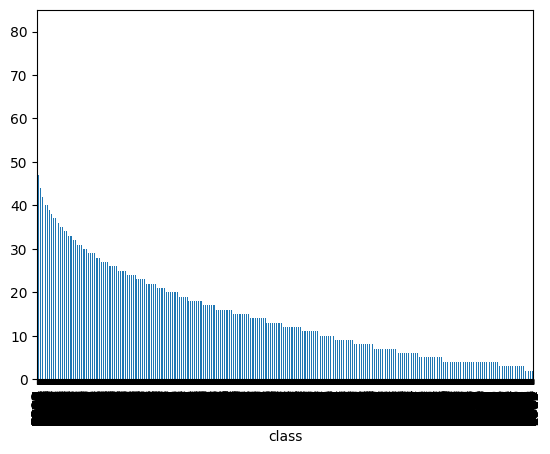

In [9]:
df_train['class'].value_counts().plot(kind='bar')

<Axes: xlabel='group'>

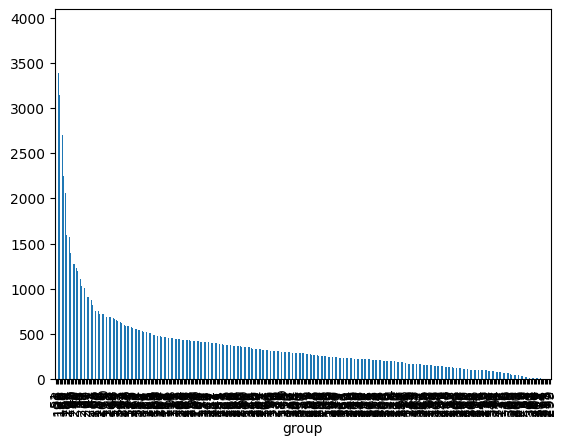

In [7]:
df_train['group'].value_counts().plot(kind='bar')

In [9]:
def custom_groupby(x):
    return pd.Series(dict(
        label = x['class'].values[0],
        group = x['group'].values[0],
        name = x['name'].values[0],
        count = len(x)
    ))

In [10]:
compress = df_train.groupby('class').apply(custom_groupby).sort_values('count', ascending=False)
compress.head()

,label,group,name,count
class,,,,
7592,7592,205,107681.jpg,81
7488,7488,205,106330.jpg,76
5676,5676,184,80916.jpg,75
8227,8227,291,118510.jpg,74
1031,1031,25,7775.jpg,71


In [11]:
compress[1000:1010]

,label,group,name,count
class,,,,
4982,4982,177,67575.jpg,29
3845,3845,79,42028.jpg,29
8156,8156,307,117132.jpg,29
4986,4986,180,67680.jpg,29
8164,8164,288,117287.jpg,29
9190,9190,353,134647.jpg,29
4656,4656,135,60771.jpg,29
9185,9185,322,134567.jpg,29
5086,5086,154,69611.jpg,29


In [37]:
# for i in range(2000,3000):
#     name = compress['name'].iloc[i]
#     label = compress['label'].iloc[i]
#     group = compress['group'].iloc[i]
#     img = Image.open(f'./{DIRECTROY}/train/{name}').convert('RGB')
#     img.save(f'./{DIRECTROY}/reduced_train/{label}_{name}')

In [12]:
from os import walk

f = []
for (dirpath, dirnames, filenames) in walk(f'./{DIRECTROY}/reduced_train'):
    f.extend(filenames)
    break
len(f)

3000

In [13]:
taken_class = set()
label_class = set()
id2class = dict()

In [14]:
for name in f:
    text = name.split('_')
    clas = int(text[0])
    label = ' '.join(text[1:]).split('.')[0]
    
    if label.isnumeric():
        continue
    taken_class.add(clas)
    label_class.add(label)
    id2class[clas] = label
    

### Reduced to 640 labels and 28k objects

In [15]:
len(taken_class), len(label_class)

(991, 640)

In [16]:
df_reduced = df_train[df_train['class'].isin(taken_class)]

In [17]:
df_reduced['label'] = df_reduced['class'].apply(lambda x: id2class[x])

C:\Users\Admin\AppData\Local\Temp\ipykernel_54488\777148962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['label'] = df_reduced['class'].apply(lambda x: id2class[x])


In [18]:
id2newid = dict()
newid = 0
for clas in label_class:
    id2newid[clas] = newid
    newid += 1
df_reduced['newid'] = df_reduced['label'].apply(lambda x: id2newid[x])

C:\Users\Admin\AppData\Local\Temp\ipykernel_54488\255550209.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['newid'] = df_reduced['label'].apply(lambda x: id2newid[x])


In [19]:
len(df_reduced['newid'].unique())

640

In [20]:
df_reduced.to_csv(f'./{DIRECTROY}/reduced_train.csv', index=False)

In [21]:
df_test = pd.read_csv(f'{DIRECTROY}/test_kaggletest.csv')
df_reduced_test = df_test[df_test['class'].isin(taken_class)]

In [23]:
df_reduced_test['label'] = df_reduced_test['class'].apply(lambda x: id2class[x])
df_reduced_test['newid'] = df_reduced_test['label'].apply(lambda x: id2newid[x])
df_reduced_test.to_csv(f'./{DIRECTROY}/reduced_test.csv', index=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_54488\3162878561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced_test['label'] = df_reduced_test['class'].apply(lambda x: id2class[x])
C:\Users\Admin\AppData\Local\Temp\ipykernel_54488\3162878561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced_test['newid'] = df_reduced_test['label'].apply(lambda x: id2newid[x])


In [24]:
df_reduced

,name,class,group,label,newid
147,148.jpg,19,0,pink scarf,303
148,149.jpg,19,0,pink scarf,303
149,150.jpg,19,0,pink scarf,303
150,151.jpg,19,0,pink scarf,303
151,152.jpg,19,0,pink scarf,303
...,...,...,...,...,...
141920,141921.jpg,9688,334,blue umbrella,331
141921,141922.jpg,9688,334,blue umbrella,331
141922,141923.jpg,9688,334,blue umbrella,331
141923,141924.jpg,9688,334,blue umbrella,331
